In [3]:
pip install snowflake-connector-python pandas langchain_community langchain_text_splitters beautifulsoup4 pymilvus langchain_milvus langchain_huggingface huggingface_hub langchain_openai requests python-dotenv matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 97.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 219.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 233.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.4/223.4 kB 230.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.4/481.4 kB 252.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 197.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 238.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 224.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 241.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 187.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 212.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 206.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━

In [14]:
# only execute once!!
#!cat 2022-IT-Root-CA.pem >> `python -m certifi`

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [51]:
import os
import mailbox
import re

import pandas as pd

def clean_addresses(addresses, lookupcsv):
    if addresses is None:
        return []
#   print(addresses)
    addresses = addresses.replace("\'", "")
    addressList = re.split('[,;]', addresses)
    cleanList = []
    for address in addressList:
        cleanAddress = clean_address(address, lookupcsv)
        cleanList.append(cleanAddress)
#       print(cleanAddress)
    return cleanList

def clean_address(address, lookupcsv):
#   print('Dirty:\t' + address)
    address = address.replace("<", "")
    address = address.replace(">", "")
    address = address.replace("\"", "")
    address = address.replace("\n", " ")
    address = address.replace("MAILER-DAEMON", "")
    address = address.lower().strip()

    with open(lookupcsv, 'rt') as lookupfile:
        lookupdata = lookupfile.readlines()
    for line in lookupdata:
        name = line.split(',')[0]
        if address == name:
            address = line.split(',')[-1].strip()

    email = None
    for word in address.split(' '):
        emailRegex = re.compile(
            "^[a-zA-Z0-9._%-]+@[a-zA-Z0-9._%-]+.[a-zA-Z]{2,6}$"
            )
        email = re.match(emailRegex, word)
        if email is not None:
            cleanEmail = email.group(0)
    if email is None:
        if address.split(' ')[-1].find('@') > -1:
            cleanEmail = address.split(' ')[-1].strip()
        elif address.split(' ')[-1].find('?') > -1:
            cleanEmail = 'n/a'
        else:
            cleanEmail = address
              
#    print('Clean:\t' + cleanEmail)
    return cleanEmail

def get_body(message):
    try:
        sm = str(message)
        body_start = sm.find('iamunique', sm.find('iamunique')+1)
        body_start = sm.find('Content-Transfer-Encoding', body_start+1)
        body_start = sm.find('\n', body_start+1)+1
    
        body_end = sm.find('From: ', body_start + 1)
        if body_end == -1:
            body_end = sm.find('iamunique', body_start + 1)
            body_end = sm.find('\n', body_end - 25)
        body = sm[body_start:body_end]

        body = body.replace("=20\n", "")
        body = body.replace("=FC", "ü")
        body = body.replace("=F6", "ö")
        body = body.replace("=84", "\"")
        body = body.replace("=94", "\"")
        body = body.replace("=96", "-")
        body = body.replace("=92", "\'")
        body = body.replace("=93", "\"")
        body = body.replace("=E4", "ä")
        body = body.replace("=DF", "ss")
        body = body.replace("=", "")
        body = body.replace("\"", "")
        body = body.replace("\'", "")
    except:
        body = "N/A"
    #print("---<<----")
    #print(body)
    #print()
    
    return body

def write_table(mboxfile, mailTable, pathToCleanup):
    for message in mailbox.mbox(mboxfile):
        cleanFrom = clean_address(message['From'], pathToCleanup)
        cleanTo = clean_addresses(message['To'], pathToCleanup)
        cleanCc = clean_addresses(message['Cc'], pathToCleanup)
        mailTable.append([
            cleanFrom,
            cleanTo,
            cleanCc,
            message['Date'],
            message['Subject'],
            get_body(message)
            ])
   
pathToEmails  = './'
pathToCleanup = './cleanup.csv'
mboxfiles = [os.path.join(dirpath, f)
	     for dirpath, dirnames, files in os.walk(pathToEmails)
	     for f in files if f.endswith('mbox')]
mailTable = []
#print(mboxfiles)

for mboxfile in mboxfiles:
#   print(mboxfile)
    write_table(mboxfile, mailTable, pathToCleanup)

m = pd.DataFrame(mailTable)
m.columns = ['From', 'To', 'Cc', 'Date', 'Subject', 'Body']


In [5]:
display(m)

,From,To,Cc,Date,Subject,Body
0,ionut_rusu_2013@yahoo.ro.invalid,"[users@activemq.apache.org, ionut_rusu_2013@ya...",[],"Mon, 1 Apr 2024 07:00:48 +0000 (UTC)",Re: Artemis 2.32.0 some expired messages are lost,"\nHello Justin,Did you have time to look into ..."
1,simon@72.services,[users@activemq.apache.org],[],"Mon, 1 Apr 2024 16:00:19 +0000",Unable to login ot web interface when run with...,MIME-Version: 1.0\nX-OriginatorOrg: 72.service...
2,jbertram@apache.org,[users@activemq.apache.org],[],"Mon, 1 Apr 2024 11:04:38 -0500",Re: Unable to login ot web interface when run ...,\nYoure hitting AMQ-9460 [1]. It will be fixed...
3,simon@72.services,[users@activemq.apache.org],[],"Mon, 1 Apr 2024 16:07:28 +0000",Re: Unable to login ot web interface when run ...,MIME-Version: 1.0\nX-OriginatorOrg: 72.service...
4,milovidoff@gmail.com,[users@activemq.apache.org],[],"Tue, 2 Apr 2024 00:06:35 +0300",Re: feasibility of connecting ActiveMQ Artemis...,"\nThanks Justin, Clebert.\nFor some reason I d..."
...,...,...,...,...,...,...
1068,vilius.sumskas@rivile.lt.invalid,[users@activemq.apache.org],[],"Thu, 17 Apr 2025 11:55:32 +0000",RE: IP address whitelisting for Artemis users,MIME-Version: 1.0\nX-OriginatorOrg: rivile.lt\...
1069,bruscinodf@gmail.com,[users@activemq.apache.org],[],"Thu, 17 Apr 2025 15:24:22 +0200",Re: IP address whitelisting for Artemis users,"\nYes, you can use a connection-router to allo..."
1070,bruscinodf@gmail.com,[users@activemq.apache.org],[],"Thu, 17 Apr 2025 15:25:25 +0200",Re: IP address whitelisting for Artemis users,"\nIn my previous example there is an error, I ..."
1071,milovidoff@gmail.com,[users@activemq.apache.org],[],"Thu, 17 Apr 2025 16:41:03 +0300",Re: limiting queue creation in JMS durable sub...,"\nThe producer is not aware of consumers, so w..."


In [7]:
from dotenv import load_dotenv
from langchain_core.documents import Document

In [8]:
from uuid import uuid4
documents = [
        Document(page_content="Sender: " + From +"\n" + "Date: " + Date + "\n" + "Subject: " + Subject+ "\n\n" + Body, metadata={"Sender": From, "Date": Date, "Subject": Subject}, id=uuid4()) 
        for Body, From, To, Date, Subject in zip(m['Body'], m['From'], m['To'], m['Date'], m['Subject'])
    ]
print(len(documents))

1073


In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_milvus import Milvus
from dotenv import load_dotenv
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
# Initialize chunking
text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)

chunked_docs = text_splitter.split_documents(documents)

In [10]:
# Initialize HuggingFace embeddings
embeddings = HuggingFaceEmbeddings(model_name="mixedbread-ai/mxbai-embed-large-v1")

# Store in Milvus
vectorstore = Milvus.from_documents(  
    documents=documents,
    embedding=embeddings,
    connection_args={"uri": "./milvus_demo.db"},  
    drop_old=False, 
    index_params={"index_type": "FLAT", "metric_type": "L2"},
)

print("Successfully stored embeddings in Milvus!")

/opt/app-root/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Successfully stored embeddings in Milvus!


In [11]:
import getpass
access_token = getpass.getpass("Enter your MODELS.CORP API KEY for granite-3.1-8b-instruct")
model_api_url = "https://granite-3-1-8b-instruct--apicast-production.apps.int.stc.ai.prod.us-east-1.aws.paas.redhat.com/v1"
model = "/data/granite-3.1-8b-instruct"

Enter your MODELS.CORP API KEY for granite-3.1-8b-instruct ········


In [16]:
llm = ChatOpenAI(model=model, api_key=access_token, base_url=model_api_url, temperature=0.1)

# Define the prompt template
PROMPT_TEMPLATE = """
Human: You are an AI assistant, and provides answers to questions by using fact based and statistical information when possible.
Use the following pieces of information to provide a complete answer to the question enclosed in <question> tags.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
<context>
{context}
</context>

<question>
{question}
</question>

The response should be specific and use statistics or numbers when possible.

Assistant:"""

# Create the prompt template
prompt = PromptTemplate(
    template=PROMPT_TEMPLATE, input_variables=["context", "question"]
)
retriever = vectorstore.as_retriever()

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Create the chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [17]:
query = "Summarize what was discussed on the topic 'Additional Info on certificate based authentication errors'. Who is involved in this discussion? Add the dates when people sent their answers; Indicate if the issue was resolved or not."

res = rag_chain.invoke(query)
print("--------------------------\n")
print("Question : ",query)
print("\n--------------------------\n")
print("Response : ",res)
print("\n--------------------------")

--------------------------

Question :  Summarize what was discussed on the topic 'Additional Info on certificate based authentication errors'. Who is involved in this discussion? Add the dates when people sent their answers; Indicate if the issue was resolved or not.

--------------------------

Response :  The discussion revolves around resolving certificate-based authentication errors in an Apache ActiveMQ Artemis broker. The participants in this discussion are Shiv Kumar Dixit (shivkumar.dixit@it.eurofinseu.com.invalid) and Domenico (bruscinodf@gmail.com).

Shiv initially encountered an issue where the broker rejected a connection after creating three good connections and one consumer per connection. He then attempted to switch to using OPENSSL as the sslProvider but faced a NoClassDefFoundError related to io/netty/internal/tcnative/SSLPrivateKeyMethod.

Domenico responded on April 14, 2025, at 10:21:42 +0200, stating that Shiv needed to add the netty-tcnative artifact to his class

In [78]:
query = "What can I do if I encounter SSL issues with the broker? Point me to some advice from the apache contributors. Are there any mails refering to this issue already? If so give me their Subject"

res = rag_chain.invoke(query)
print("--------------------------\n")
print("Question : ",query)
print("\n--------------------------\n")
print("Response : ",res)
print("\n--------------------------")

--------------------------

Question :  What can I do if I encounter SSL issues with the broker? Point me to some advice from the apache contributors. Are there any mails refering to this issue already? If so give me their Subject

--------------------------

Response :  Based on the provided context, here are some pieces of advice from Apache contributors regarding SSL issues with the broker:

1. Ensure that you have the correct SSL provider configured. In your case, you've switched from the JDK default to OPENSSL.

2. When using OpenSSL, the `-Djavax.net.debug3Dssl,handshake` flag might not work for logging SSL-related errors.

3. If you're experiencing issues with invalid certificates, the broker should log an error when a client connects with an invalid certificate. In your case, you've mentioned seeing the error `javax.net.ssl.SSLHandshakeException: Empty server certificate chain` in the broker log.

4. To gain more insight into the SSL handshake process, you can enable detailed l

In [84]:
query = "List me all the subjects during the first week of december 2024"

res = rag_chain.invoke(query)
print("--------------------------\n")
print("Question : ",query)
print("\n--------------------------\n")
print("Response : ",res)
print("\n--------------------------")

--------------------------

Question :  List me all the subjects during the first week of december 2024

--------------------------

Response :  Based on the provided context, there are no emails dated within the first week of December 2024. Therefore, I cannot list any subjects from that time period. The earliest email in the context is dated January 31, 2025.

--------------------------


In [18]:
query = """
Given a panda dataframe named m configured the colums['From', 'To', 'Cc', 'Date', 'Subject', 'Body'] that is holding the content of the mailing list users@activemq.apache.org, write me the python code to list all the messages of october 2024.
The field Date is a String and will have to be converted into a date, the format of the date is encoded like this 'Mon, 1 Apr 2024 16:00:19 +0000'  utc=True will have to be specified in the conversion;

For every unique subject in the list, execute the following code chunk:
res = rag_chain.invoke('Summarize what was discussed on the topic '+ row['Subject'] +'. Who is involved in this discussion? Add the dates when people sent their answers; Indicate if the issue was resolved or not.')
print('--------------------------\n')
print('Question : ",query)
print('\n--------------------------\n')
print('Response : ',res)
print('\n--------------------------')

where query is a string asking to summarize the subject of the mail in the list
"""

res = rag_chain.invoke(query)
print("--------------------------\n")
print("Question : ",query)
print("\n--------------------------\n")
print("Response : ",res)
print("\n--------------------------")

--------------------------

Question :  
Given a panda dataframe named m configured the colums['From', 'To', 'Cc', 'Date', 'Subject', 'Body'] that is holding the content of the mailing list users@activemq.apache.org, write me the python code to list all the messages of october 2024.
The field Date is a String and will have to be converted into a date, the format of the date is encoded like this 'Mon, 1 Apr 2024 16:00:19 +0000'  utc=True will have to be specified in the conversion;

For every unique subject in the list, execute the following code chunk:
res = rag_chain.invoke('Summarize what was discussed on the topic '+ row['Subject'] +'. Who is involved in this discussion? Add the dates when people sent their answers; Indicate if the issue was resolved or not.')
print('--------------------------
')
print('Question : ",query)
print('
--------------------------
')
print('Response : ',res)
print('
--------------------------')

where query is a string asking to summarize the subject of th

In [35]:
# Define the prompt template
PROMPT_TEMPLATE = """
Human: You are an AI assistant, and provides a python script to address the questions by using fact based and statistical information when possible.
Use the following pieces of information to provide a functioning pythion script to answer the question enclosed in <question> tags.
If you don't know the answer return an empty script.
The output can only contain valid python code. You are forbidden to write the script in a markdown format. You are forbidden to write a conclusion at the end. The result of your writting will be executed directly.
<context>
{context}
</context>

<question>
{question}
</question>
Assistant:"""

# Create the prompt template
prompt = PromptTemplate(
    template=PROMPT_TEMPLATE, input_variables=["context", "question"]
)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Create the chain
rag_chain_script = (
    {"context": vectorstore.as_retriever() | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

Executing :  import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Assuming 'm' is already defined as a pandas DataFrame
m['Date'] = pd.to_datetime(m['Date'], utc=True)

# Filter data for the specified time frame
m_filtered = m[(m['Date'] >= '2024-04-01') & (m['Date'] <= '2024-12-31')]

# Count the number of emails sent by each contributor
contributor_counts = m_filtered['From'].value_counts()

# Plot the top contributors
top_contributors = contributor_counts.head(10)  # Change the number as needed
top_contributors.plot(kind='bar')
plt.title('Top Contributors (April 2024 - December 2024)')
plt.xlabel('Contributor')
plt.ylabel('Number of Emails')
plt.show()


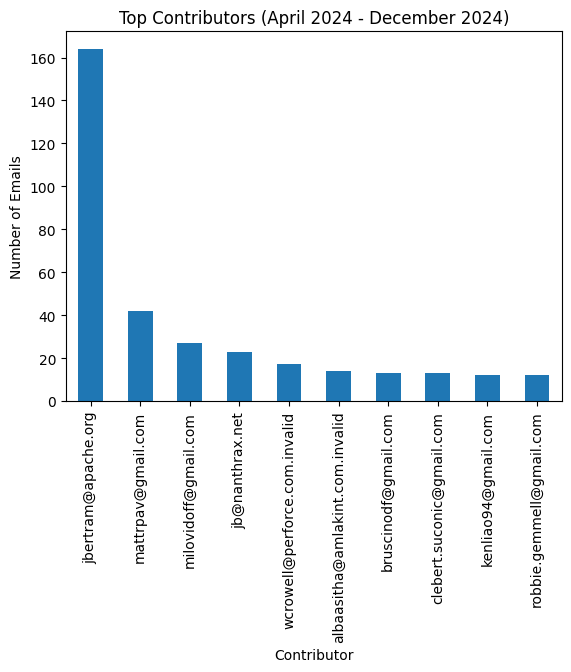

In [47]:
query = """
Given a panda dataframe named m configured the colums['From', 'To', 'Cc', 'Date', 'Subject', 'Body'] that is holding the content of the mailing list users@activemq.apache.org, i want to plot the top contributors during the time frame April 2024 to december 2024.
The field Date is a String and will have to be converted into a date, the format of the date is encoded like this 'Mon, 1 Apr 2024 16:00:19 +0000'  utc=True will have to be specified in the conversion;
"""

def extract_first_code_chunk(markdown_file):
    lines = markdown_file.split("\n")

    code_chunk = []
    in_code_block = False

    for line in lines:
        if line.strip().startswith('```'):
            in_code_block = not in_code_block
        elif in_code_block and not line.strip().startswith('```'):
            code_chunk.append(line)

    return '\n'.join(code_chunk)


res = rag_chain_script.invoke(query)
print("Executing : ",extract_first_code_chunk(res))
exec(extract_first_code_chunk(res))

Executing :  import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Assuming 'm' is already defined as a pandas DataFrame
m['Date'] = pd.to_datetime(m['Date'], utc=True)
m['Day_of_Week'] = m['Date'].dt.day_name()

# Group by day of week and count the number of messages
daily_messages = m.groupby('Day_of_Week')['Subject'].count().reset_index()

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(daily_messages['Day_of_Week'], daily_messages['Subject'])
plt.xlabel('Day of the Week')
plt.ylabel('Number of Messages')
plt.title('Average Number of Messages per Day of the Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


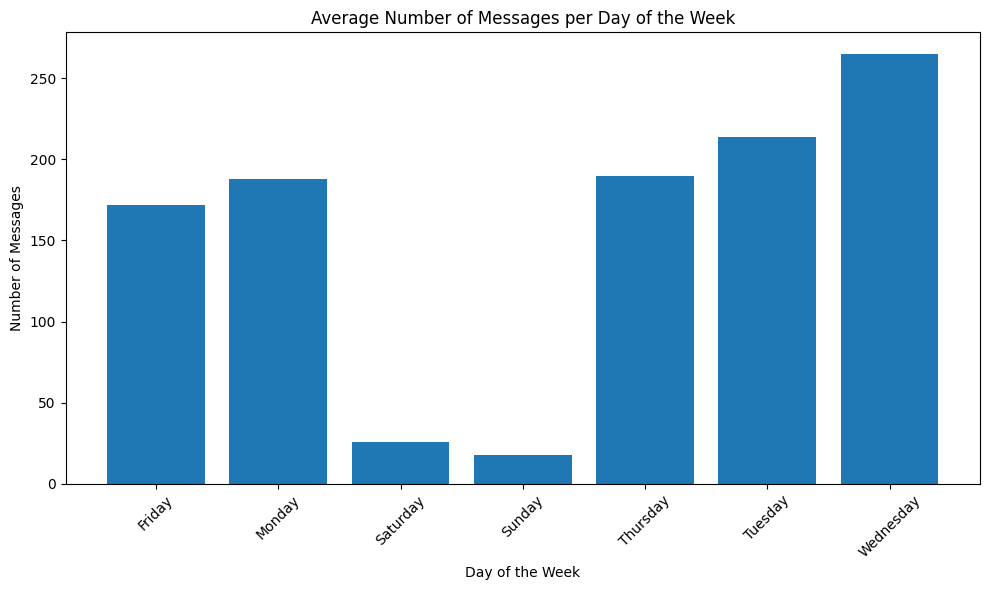

In [83]:
query = """
Given a panda dataframe named m configured the colums['From', 'To', 'Cc', 'Date', 'Subject', 'Body'] that is holding the content of the mailing list users@activemq.apache.org, plot me per each day of the week the number of messages of that day in average
The field Date is a String and will have to be converted into a date, the format of the date is encoded like this 'Mon, 1 Apr 2024 16:00:19 +0000'  utc=True will have to be specified in the conversion;
"""

def extract_first_code_chunk(markdown_file):
    lines = markdown_file.split("\n")

    code_chunk = []
    in_code_block = False

    for line in lines:
        if line.strip().startswith('```'):
            in_code_block = not in_code_block
        elif in_code_block and not line.strip().startswith('```'):
            code_chunk.append(line)

    return '\n'.join(code_chunk)


res = rag_chain_script.invoke(query)
print("Executing : ",extract_first_code_chunk(res))
exec(extract_first_code_chunk(res))

In [75]:
query = """
Given a panda dataframe named m configured the colums['From', 'To', 'Cc', 'Date', 'Subject', 'Body'] that is holding the content of the mailing list users@activemq.apache.org, write me the python code to list all the messages of the first week of april 2025.
The field Date is a String and you need to convert it into a date obbject, the format of the date is encoded like this 'Mon, 1 Apr 2024 16:00:19 +0000'

don't use weekofyear
avoid: AttributeError: 'DatetimeProperties' object has no attribute 'week'
avoid: AttributeError: 'DatetimeProperties' object has no attribute 'week'

And then for every unique subject in the list, execute the following code chunk (note that if two entries have the same subject name, only execute the chunk for one and skip the others):
res = rag_chain.invoke('Summarize what was discussed on the topic '+ row['Subject'] +'. Who is involved in this discussion? Add the dates when people sent their answers; Indicate if the issue was resolved or not.')
print('--------------------------\n')
print('Question : ",query)
print('\n--------------------------\n')
print('Response : ',res)
print('\n--------------------------')

where query is a string asking to summarize the subject of the mail in the list
"""

def extract_first_code_chunk(markdown_file):
    lines = markdown_file.split("\n")

    code_chunk = []
    in_code_block = False

    for line in lines:
        if line.strip().startswith('```'):
            in_code_block = not in_code_block
        elif in_code_block and not line.strip().startswith('```'):
            code_chunk.append(line)

    return '\n'.join(code_chunk)


res = rag_chain_script.invoke(query)
print("Executing : ",extract_first_code_chunk(res))
exec(extract_first_code_chunk(res))

Executing :  import pandas as pd
from datetime import datetime

# Assuming 'm' is the given DataFrame
m['Date'] = pd.to_datetime(m['Date'], format='%a, %d %b %Y %H:%M:%S %z')

# Filter messages from the first week of April 2025
first_week_april = m[(m['Date'].dt.year == 2025) & (m['Date'].dt.month == 4) & (m['Date'].dt.day <= 7)]

# List all the messages
for index, row in first_week_april.iterrows():
    print(f"From: {row['From']}")
    print(f"To: {row['To']}")
    print(f"Cc: {row['Cc']}")
    print(f"Date: {row['Date']}")
    print(f"Subject: {row['Subject']}")
    print(f"Body: {row['Body']}")
    print("\n")

# Unique subjects
unique_subjects = first_week_april['Subject'].unique()

# For each unique subject, execute the code chunk
for subject in unique_subjects:
    relevant_rows = first_week_april[first_week_april['Subject'] == subject]
    if not relevant_rows.empty:
        query = f"Summarize what was discussed on the topic {subject}. Who is involved in this discussion? Add t